# LIGHT CURVE SINE WAVES PERIOD FITTING

In [43]:
from AROMA import *
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
%matplotlib widget

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

def powerfunc_ten(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6,amp7,shift7,amp8,shift8,amp9,shift9,amp10,shift10):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    shifted4=amp4*shift(sinepw,shift4)
    shifted5=amp5*shift(sinepw,shift5)
    shifted6=amp6*shift(sinepw,shift6)
    shifted7=amp1*shift(sinepw,shift7)
    shifted8=amp2*shift(sinepw,shift8)
    shifted9=amp3*shift(sinepw,shift9)
    shifted10=amp4*shift(sinepw,shift10)
    return shifted1+shifted2+shifted3+shifted4+shifted5+shifted6+shifted7+shifted8+shifted9+shifted10
print('def: powerfunc_ten(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6,amp7,shift7,amp8,shift8,amp9,shift9,amp10,shift10)')

def powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    shifted4=amp4*shift(sinepw,shift4)
    shifted5=amp5*shift(sinepw,shift5)
    shifted6=amp6*shift(sinepw,shift6)
    return shifted1+shifted2+shifted3+shifted4+shifted5+shifted6
print('def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)')

def powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    shifted4=amp4*shift(sinepw,shift4)
    return shifted1+shifted2+shifted3+shifted4
print('def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)')
      
def powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3):
    shifted1=amp1*shift(sinepw,shift1)
    shifted2=amp2*shift(sinepw,shift2)
    shifted3=amp3*shift(sinepw,shift3)
    return shifted1+shifted2+shifted3
print('def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)')
      
def powerfuncsingle(hpp,amp1,shift1):
    shifted1=amp1*shift(sinepw,shift1)
    return shifted1
print('def: powerfuncsingle(hpp,amp1,shift1)')

def: find_nearest(array, value)
def: powerfunc_ten(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6,amp7,shift7,amp8,shift8,amp9,shift9,amp10,shift10)
def: powerfunc_six(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4,amp5,shift5,amp6,shift6)
def: powerfunc_four(hpp,amp1,shift1,amp2,shift2,amp3,shift3,amp4,shift4)
def: powerfunc(hpp,amp1,shift1,amp2,shift2,amp3,shift3)
def: powerfuncsingle(hpp,amp1,shift1)


In [10]:
import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

'/Users/nguyendat/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping'

### SINE WAVES FITTING
We now proceed to fitting multiple periods as compounded signal to compare with the data.
The periodogram is generated with the fourier transform(?)

**Note that the data is dissected differently: half or full of sector 36/37**

In [11]:
data = pd.read_csv(data_path, header=0, delimiter='\t')
plotPath = join(homedir, 'plots')

# data = data.query('TIME < 2293') # first half of sector 36 
# data = data.query('TIME > 2293 & TIME < 2306') # second half of sector 36 
# data = data.query('TIME < 2306') # full of sector 36

# data = data.query('TIME > 2306 & TIME < 2320') # first half of sector  37 
# data = data.query('TIME > 2320') # second half of sector  37 
# data = data.query('TIME > 2306') # full of sector 37

data = data # full light curve

time=data.TIME*24 # to hours
lc  =data.PSF_FLUX_NORM
elc =data.PSF_EFLUX
fit_dir = join(homedir,'notebooks', 'periodSineFit_metadata')
# fit_dir = '/Users/fuda/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/notebooks/periodSineFit_metadata/'

# Replace data with test sine wave
mu, sigma = 1.0, 0.013 # mean and standard deviation
noise = random.normal(mu, sigma, len(time))
period1 = 5.28
period2 = 5.23
period3 = 5.28
period4 = 5.45

sinelc = 1.0+0.010*np.sin(2*np.pi*(time/period1))#+noise
#sinelc2 = 1.0+0.010*np.sin(2*np.pi*(time/period2))+noise+0.010*np.sin(2*np.pi*(time/period3))
#sinelc3 = 1.0+0.003*np.sin(2*np.pi*(time/period2))+noise+0.008*np.sin(2*np.pi*(time/period3))+0.004*np.sin(2*np.pi*(time/period4))

#elc=np.ones(10000)/1000.
#period = 15.
#lc = 0.5*np.sin(2*np.pi*(time/period))

#frequen = np.linspace(0.003,10.,100000)
periodmax=6.
periodmin=4.
frequen = np.linspace(1/periodmax,1/periodmin,1000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
clp = pyPeriod.Gls((time,lc,elc), norm="ZK", freq=frequen,ofac=10)

# Calculate the Periodogram for the Window Function
#wlp = pyPeriod.Gls((wtime,window), norm="ZK", freq=frequen,ofac=10)
#clp.info

sinelp=pyPeriod.Gls((time,sinelc), norm="ZK", freq=frequen,ofac=10)
#sinelp2=pyPeriod.Gls((time,sinelc2), norm="ZK", freq=frequen,ofac=10)
#sinelp3=pyPeriod.Gls((time,sinelc3), norm="ZK", freq=frequen,ofac=10)

### PLOTS OF MULTIPLE N-SINE WAVES FIT

Plotting difference N-sine waves fit, with the option to refit the periods of power function.

### SHOULD REREAD CODE FOR UNDERSTANDING

**Three sine-waves guesses**

`guess=[4.6, 4.96, 5.26] #hours`

**Six sine-waves guesses**

`guess=[4.63, 4.93, 4.98, 5.02, 5.26, 5.9] #hours`

In [51]:
fr = clp.freq
pw = clp.power
hpp = 1./fr

refindex=find_nearest(hpp,5.28)
#Window function:
#wfr = wlp.freq
#wpw = wlp.power
#whpp = 1./wfr

sinefr = sinelp.freq
sinepw = sinelp.power
sinehpp=1./sinefr

# sinefr2 = sinelp2.freq
# sinepw2 = sinelp2.power
# sinehpp2=1./sinefr2

# sinefr3 = sinelp3.freq
# sinepw3 = sinelp3.power
# sinehpp3=1./sinefr3

# redo_model=float(input('Re-fit models?'))

redo_model = 0
#==========================================
# Fit Solution with Single Sine Wave
if redo_model==1:
    fii=200
    ssr=np.zeros([fii])
    best_ssr=99999.
    for ii in range(fii):
        guess=[rand(1)*5.26,rand(1)*600-300.]
        try:
            params, cov = curve_fit(powerfuncsingle, hpp, pw, guess,method='lm')
        except RuntimeError:
            print('Did not converge')

        #print('Fitted parameters:',params)
        fittedmodel=powerfuncsingle(hpp,params[0],params[1])
        ssr[ii]=np.sum(np.power(pw - fittedmodel, 2))
        # print(ii,"  SSR:",ssr[ii], " Best SSR:", best_ssr)
        if ssr[ii] < best_ssr:
            print('Bingo!')
            best_ssr=ssr[ii]
            best_solution=params

    params_singlesine=best_solution
    with open(join(fit_dir,'best-fit-single-sinewave-parameters.pkl'), 'wb') as output:
        pickle.dump(params_singlesine, output, pickle.HIGHEST_PROTOCOL)
else:
    with open(join(fit_dir,'best-fit-single-sinewave-parameters.pkl'), 'rb') as input:
        params_singlesine = pickle.load(input)

fittedmodel_single=powerfuncsingle(hpp,params_singlesine[0],params_singlesine[1])
# print, "Best-fit single sine parameters:", params_singlesine

redo_model = 1
#==========================================
# Fit the periodogram with a combination of three sine waves
if redo_model==1:
    search=700.
    fii=2000
    ssr=np.zeros([fii]) # Variable will store sum of squared residuals
    best_ssr_three=99999.
    for ii in range(fii):
        guess=[random.random()*4.6,random.random()*search-search/2.,
               random.random()*4.96,random.random()*search-search/2.,
               random.random()*5.26,random.random()*search-search/2.]
        try:
            params, cov = curve_fit(powerfunc, hpp, pw, guess,method='lm')
        except RuntimeError:
            print('Did not converge')
        #print('Fitted parameters:',params)
        fittedmodel=powerfunc(hpp,*params)
        ssr[ii]=np.sum(np.power(pw - fittedmodel, 2))
        # print('Three: ',ii, "  SSR:",ssr[ii], "Best SSR:",best_ssr_three)
        if ssr[ii] < best_ssr_three:
            print('Bingo!')
            best_ssr_three=ssr[ii]
            best_solution_three=params

    params_three=best_solution_three
    with open(join(fit_dir,'best-fit-three-sinewaves-parameters.pkl'), 'wb') as output:
        pickle.dump(params_three, output, pickle.HIGHEST_PROTOCOL)
else:
    with open(join(fit_dir,'best-fit-three-sinewaves-parameters.pkl'), 'rb') as input:
        params_three = pickle.load(input)

fittedmodel_three=powerfunc(hpp,*params_three)
# print, "Best-fit three sine parameters:", params_three

redo_model = 0
#==========================================
if redo_model==1:
    search=700.
    fii=2000
    ssr=np.zeros([fii]) # Variable will store sum of squared residuals
    best_ssr_six=99999.
    skip=0
    for ii in range(fii):
        guess=[random.random()*5.26,random.random()*search-search/2.,random.random()*5.9,random.random()*search-search/2.,
               random.random()*4.98,random.random()*search-search/2.,random.random()*5.02,random.random()*search-search/2.,
               random.random()*4.63,random.random()*search-search/2.,random.random()*4.93,random.random()*search-search/2.]
        try:
            params, cov = curve_fit(powerfunc_six, hpp, pw, guess,method='lm')
        except RuntimeError:
            skip=1
            print('Did not converge')
        if skip==0:
            fittedmodel=powerfunc_six(hpp,*params)
            ssr[ii]=np.sum(np.power(pw - fittedmodel, 2))
        # print('Six: ',ii, "  SSR:",ssr[ii], "Best SSR:",best_ssr_six)
        if skip==0 and ssr[ii] < best_ssr_six:
            print('Bingo!')
            best_ssr_six=ssr[ii]
            best_solution_six=params

    params_six=best_solution_six
    with open(join(fit_dir,'best-fit-six-sinewaves-parameters.pkl'), 'wb') as output:
        pickle.dump(params_six, output, pickle.HIGHEST_PROTOCOL)
else:
    with open(join(fit_dir,'best-fit-six-sinewaves-parameters.pkl'), 'rb') as input:
        params_six = pickle.load(input)

fittedmodel_six=powerfunc_six(hpp,*params_six)
# print, "Best-fit six sine parameters:", params_six

# redo_model=0
# #==========================================
# if redo_model==1:
#     search=700.
#     fii=2000
#     ssr=np.zeros([fii]) # Variable will store sum of squared residuals
#     best_ssr_ten=99999.
#     skip=0
#     for ii in range(fii):
#         guess=[random.random()*5.0,random.random()*search-search/2.,random.random()*5.0,random.random()*search-search/2.,random.random()*5.0,random.random()*search-search/2.,random.random()*5.0,
#                random.random()*search-search/2.,random.random()*5.0,random.random()*search-search/2.,random.random()*4.0,random.random()*search-search/2.,random.random()*4.0,random.random()*search-search/2.,
#                random.random()*4.0,random.random()*search-search/2.,random.random()*4.0,random.random()*search-search/2.,random.random()*4.0,random.random()*search-search/2.]
#         try:
#             params, cov = curve_fit(powerfunc_ten, hpp, pw, guess,method='lm')
#         except RuntimeError:
#             skip=1
#             print('Did not converge')
#         if skip==0:
#             fittedmodel=powerfunc_ten(hpp,*params)
#             ssr[ii]=np.sum(np.power(pw - fittedmodel, 2))
#         # print('Ten: ',ii, "  SSR:",ssr[ii], "Best SSR:",best_ssr_ten)
#         if skip==0 and ssr[ii] < best_ssr_ten:
#             print('Bingo!')
#             best_ssr_ten=ssr[ii]
#             best_solution_ten=params

#     params_ten=best_solution_ten
#     with open(join(fit_dir,'best-fit-ten-sinewaves-parameters.pkl'), 'wb') as output:
#         pickle.dump(params_ten, output, pickle.HIGHEST_PROTOCOL)
# else:
#     with open(join(fit_dir,'best-fit-ten-sinewaves-parameters.pkl'), 'rb') as input:
#         params_ten = pickle.load(input)

# fittedmodel_ten=powerfunc_ten(hpp,*params_ten)
# print, "Best-fit ten sine parameters:", params_ten

Bingo!
Bingo!
Bingo!


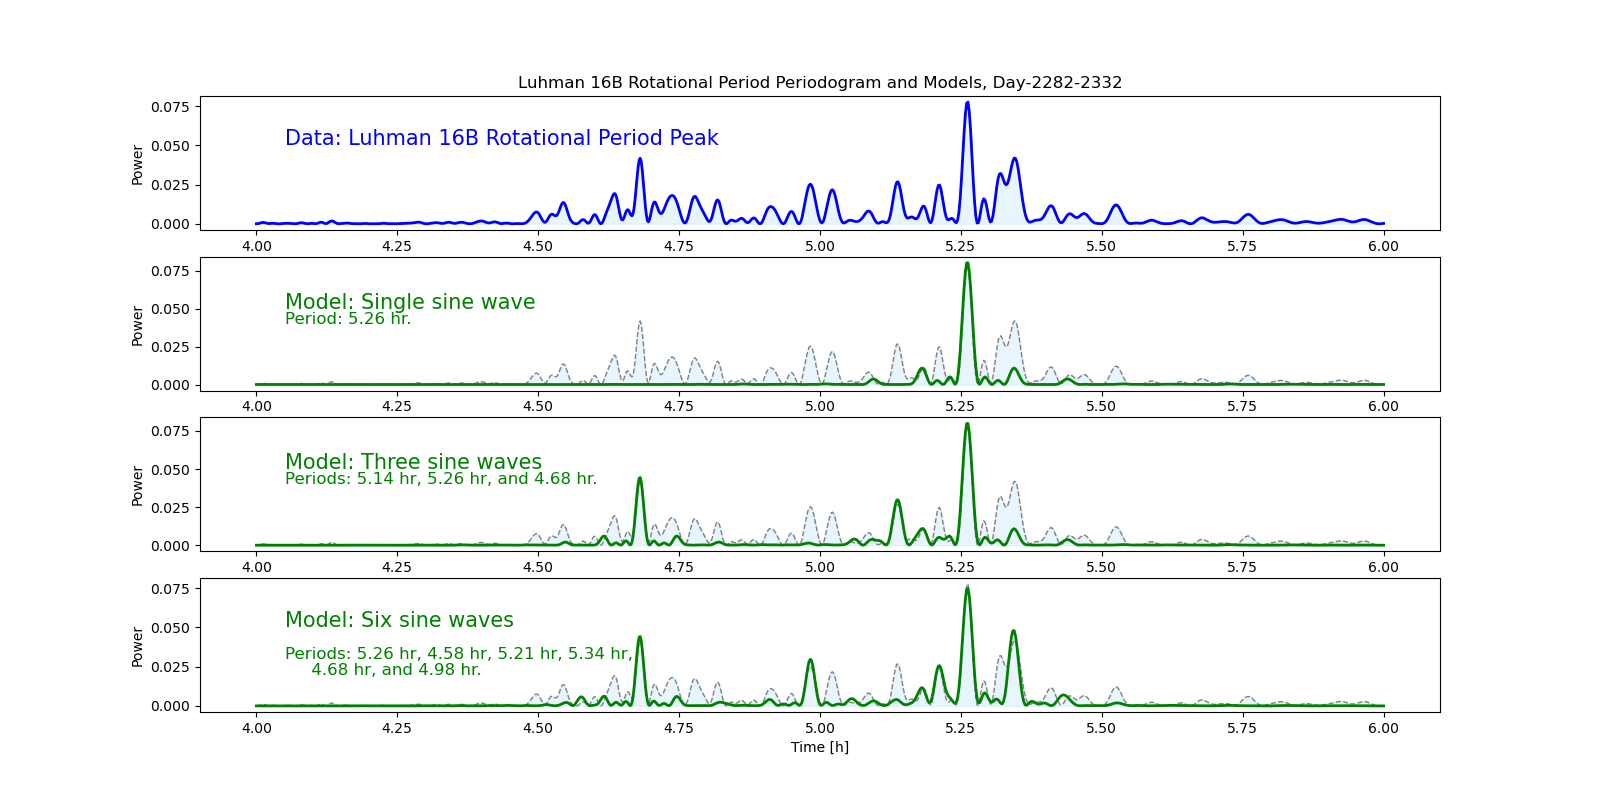

In [38]:
#==========================================
#PLOTTING
save=False

xlim=[4.0,6.0]
ylim=[0,0.025]
fig = plt.figure(figsize=(16,8))
matplotlib.rcParams.update({'font.size': 10})

plt.subplot(4,1,1)
# plt.subplot(3,1,1)
plt.text(4.05,0.05,'Data: Luhman 16B Rotational Period Peak ',horizontalalignment='left',fontsize=15,color='blue')
plt.plot(hpp, pw, '-', linewidth=2,color='blue')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.xlabel('Time [h]')
plt.ylabel('Power')
plt.title('Luhman 16B Rotational Period Periodogram and Models, Day-%i-%i'%(data.TIME.iloc[0], data.TIME.iloc[len(data.TIME)-1]))
# plt.xlim(xlim)
# plt.ylim(ylim)

plt.subplot(4,1,2)
# plt.subplot(3,1,2)
#print('Shift for single sine wave fit:',int(round(refindex+params_singlesine[1])))
peak1=hpp[refindex+int(round(params_singlesine[1]))]
plt.text(4.05,0.05,'Model: Single sine wave',horizontalalignment='left',fontsize=15,color='green')
plt.text(4.05,0.04,'Period: {pk1:.2f} hr.'.format(pk1=peak1),horizontalalignment='left',fontsize=12,color='green')
plt.plot(hpp, pw, '--', linewidth=1,color='gray')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.plot(hpp,fittedmodel_single, '-', linewidth=2,color='green')
plt.xlabel('Time [h]')
plt.ylabel('Power')
# plt.xlim(xlim)
# plt.ylim(ylim)

plt.subplot(4,1,3)
# plt.subplot(3,1,3)
peak1=hpp[refindex+int(round(params_three[1]))]
peak2=hpp[refindex+int(round(params_three[3]))]
peak3=hpp[refindex+int(round(params_three[5]))]
plt.text(4.05,0.05,'Model: Three sine waves',horizontalalignment='left',fontsize=15,color='green')
plt.text(4.05,0.04,'Periods: {pk1:.2f} hr, {pk2:.2f} hr, and {pk3:.2f} hr.'.format(pk1=peak1,pk2=peak2,pk3=peak3),horizontalalignment='left',fontsize=12,color='green')
plt.plot(hpp, pw, '--', linewidth=1,color='gray')
plt.plot(hpp, fittedmodel_three, '-', linewidth=2,color='green')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.xlabel('Time [h]')
plt.ylabel('Power')
# plt.xlim(xlim)
# plt.ylim(ylim)

plt.subplot(4,1,4)
plt.text(4.05,0.05,'Model: Six sine waves',horizontalalignment='left',fontsize=15,color='green')
peak1=hpp[refindex+int(round(params_six[1]))]
peak2=hpp[refindex+int(round(params_six[3]))]
peak3=hpp[refindex+int(round(params_six[5]))]
peak4=hpp[refindex+int(round(params_six[7]))]
peak5=hpp[refindex+int(round(params_six[9]))]
peak6=hpp[refindex+int(round(params_six[11]))]
plt.plot(hpp, pw, '--', linewidth=1,color='gray')
plt.text(4.05,0.03,'Periods: {pk1:.2f} hr, {pk2:.2f} hr, {pk3:.2f} hr, {pk4:.2f} hr,'.format(pk1=peak1,pk2=peak2,pk3=peak3,pk4=peak4),horizontalalignment='left',fontsize=12,color='green')
plt.text(4.05,0.02,'     {pk5:.2f} hr, and {pk6:.2f} hr.'.format(pk5=peak5,pk6=peak6),horizontalalignment='left',fontsize=12,color='green')
plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
plt.plot(hpp, fittedmodel_six, '-', linewidth=2,color='green')
plt.xlabel('Time [h]')
plt.ylabel('Power')
# plt.xlim(xlim)
# plt.ylim(ylim)

# plt.subplot(4,1,4)
# plt.text(4.05,0.05,'Model: Ten sine waves',horizontalalignment='left',fontsize=15,color='green')
# peak1=hpp[refindex+int(round(params_ten[1]))]
# peak2=hpp[refindex+int(round(params_ten[3]))]
# peak3=hpp[refindex+int(round(params_ten[5]))]
# peak4=hpp[refindex+int(round(params_ten[7]))]
# peak5=hpp[refindex+int(round(params_ten[9]))]
# peak6=hpp[refindex+int(round(params_ten[11]))]
# peak7=hpp[refindex+int(round(params_ten[13]))]
# peak8=hpp[refindex+int(round(params_ten[15]))]
# peak9=hpp[refindex+int(round(params_ten[17]))]
# peak10=hpp[refindex+int(round(params_ten[19]))]
# plt.plot(hpp, pw, '--', linewidth=1,color='gray')
# plt.text(4.05,0.03,'Periods: {pk1:.2f} hr, {pk2:.2f} hr, {pk3:.2f} hr, {pk4:.2f} hr,'.format(pk1=peak1,pk2=peak2,pk3=peak3,pk4=peak4),horizontalalignment='left',fontsize=12,color='green')
# plt.text(4.05,0.02,'     {pk5:.2f} hr, {pk6:.2f} hr, {pk7:.2f} hr'.format(pk5=peak5,pk6=peak6, pk7=peak7),horizontalalignment='left',fontsize=12,color='green')
# plt.text(4.05,0.01,'     {pk8:.2f} hr, {pk9:.2f} hr, {pk10:.2f} hr.'.format(pk8=peak8,pk9=peak9,pk10=peak10),horizontalalignment='left',fontsize=12,color='green')
# plt.fill_between(hpp, pw, interpolate=True, color='xkcd:light blue',alpha=0.2)
# plt.plot(hpp, fittedmodel_ten, '-', linewidth=2,color='green')
# plt.xlabel('Time [h]')
# plt.ylabel('Power')
# # plt.xlim(xlim)
# # plt.ylim(ylim)


if save:
    plt.savefig(join(plotPath,'single_sine_fit_Day-%i-%i.pdf'%(data.TIME.iloc[0], data.TIME.iloc[len(data.TIME)-1])))
plt.show()

In [47]:
params_three

array([2.98882524e-02, 6.29602281e+01, 8.05783011e-02, 8.02648993e+00,
       4.45484859e-02, 2.90885167e+02])

In [52]:
params_six

array([ 6.94290510e-02,  7.89276353e+00,  5.77807216e-03,  3.48996119e+02,
        2.39220236e-02,  2.95572203e+01,  3.92266564e-02, -2.67958914e+01,
        4.43804414e-02,  2.90885955e+02,  2.95340884e-02,  1.35318548e+02])